# Machine Learning — Price Prediction

**Goal:** Predict `TARGET(PRICE_IN_LACS)` using OLS, Ridge, and Lasso. This notebook includes detailed preprocessing, visualizations, model tuning, and evaluation.

In [36]:
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error


## Load dataset
We will load `train.csv` and `test.csv` (that we downloaded from kaggle)

In [27]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print('Train shape:', train.shape)
print('Test shape:', test.shape)
display(train.head())

Train shape: (29451, 12)
Test shape: (68720, 11)


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


## Exploratory Data Analysis (EDA)
Quick overview of missing values and basic distributions.

Series([], dtype: int64)

,count,mean,std,min,25%,50%,75%,max
UNDER_CONSTRUCTION,29451.0,0.179756,3.839908e-01,0.000000,0.000000,0.000000,0.000000,1.000000e+00
RERA,29451.0,0.317918,4.656753e-01,0.000000,0.000000,0.000000,1.000000,1.000000e+00
BHK_NO.,29451.0,2.392279,8.790913e-01,1.000000,2.000000,2.000000,3.000000,2.000000e+01
SQUARE_FT,29451.0,19802.170190,1.901335e+06,3.000000,900.021130,1175.056750,1550.688124,2.545455e+08
READY_TO_MOVE,29451.0,0.820244,3.839908e-01,0.000000,1.000000,1.000000,1.000000,1.000000e+00
RESALE,29451.0,0.929578,2.558613e-01,0.000000,1.000000,1.000000,1.000000,1.000000e+00
LONGITUDE,29451.0,21.300255,6.205306e+00,-37.713008,18.452663,20.750000,26.900926,5.991288e+01
LATITUDE,29451.0,76.837695,1.055775e+01,-121.761248,73.798100,77.324137,77.828740,1.529627e+02
TARGET(PRICE_IN_LACS),29451.0,142.898746,6.568807e+02,0.250000,38.000000,62.000000,100.000000,3.000000e+04


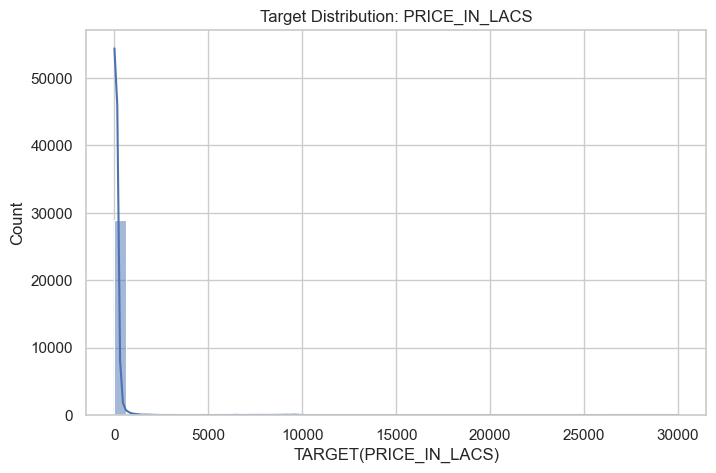

In [28]:
# Missing values summary
missing = train.isnull().sum().sort_values(ascending=False)
display(missing[missing>0].head(30))

# Describe numeric columns
display(train.describe().T)

# Histogram of target
plt.figure(figsize=(8,5))
sns.histplot(train['TARGET(PRICE_IN_LACS)'], bins=50, kde=True)
plt.title('Target Distribution: PRICE_IN_LACS')
plt.show()

## Preprocessing plan

**Steps:**
1. Handle missing values: median for numeric, mode for categorical.
2. Encode categorical variables: one-hot for nominal; binary columns kept as-is.
3. Scale numeric features using StandardScaler.
4. Optionally remove extreme outliers (capping at 99th percentile) — this cell demonstrates a conservative approach.

All preprocessing is wrapped into a `ColumnTransformer` + `Pipeline` so it is reproducible and safe for cross-validation.

In [29]:
numeric_cols = ['BHK_NO.', 'SQUARE_FT', 'LONGITUDE', 'LATITUDE']
categorical_cols = ['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'READY_TO_MOVE', 'RESALE', 'BHK_OR_RK']

# Ensure columns exist
for c in numeric_cols + categorical_cols:
    if c not in train.columns:
        raise ValueError(f'Expected column {c} not found in train.csv. Columns available: {list(train.columns)}')

# --- Fill Missing Values ---
train_proc = train.copy()
for col in numeric_cols:
    train_proc[col] = train_proc[col].fillna(train_proc[col].median())
for col in categorical_cols:
    train_proc[col] = train_proc[col].fillna(train_proc[col].mode()[0])

# Cap outliers
sq_up = train_proc['SQUARE_FT'].quantile(0.99)
train_proc = train_proc[train_proc['SQUARE_FT'] <= sq_up].reset_index(drop=True)
print('After capping, train shape:', train_proc.shape)

After capping, train shape: (29156, 12)


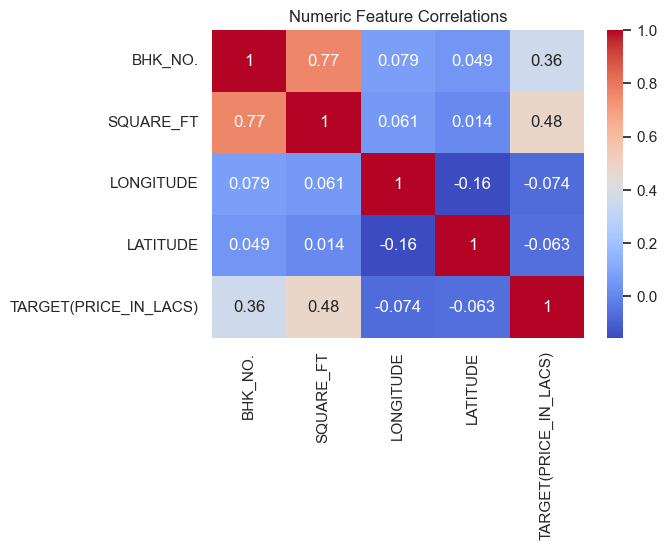

In [30]:
plt.figure(figsize=(6,4))
sns.heatmap(train_proc[numeric_cols + ['TARGET(PRICE_IN_LACS)']].corr(), annot=True, cmap='coolwarm')
plt.title('Numeric Feature Correlations')
plt.show()

In [31]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

## Train-Test Split and Log Transformation


In [60]:
X = train_proc.drop(columns=['TARGET(PRICE_IN_LACS)'])
y = train_proc['TARGET(PRICE_IN_LACS)']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('X_train:', X_train.shape, 'X_test:', X_test.shape)

# Log-transform target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

X_train: (23324, 11) X_test: (5832, 11)


### Model 1: OLS (Linear Regression)

In [61]:
ols_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

ols_pipeline.fit(X_train, y_train_log)
y_pred_ols_log = ols_pipeline.predict(X_test)
y_pred_ols = np.expm1(y_pred_ols_log)  # inverse log transform

rmse_ols = root_mean_squared_error(y_test, y_pred_ols)
mae_ols = mean_absolute_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)

print(f'OLS — RMSE: {rmse_ols:.4f} | MAE: {mae_ols:.4f} | R²: {r2_ols:.4f}')

OLS — RMSE: 118.9042 | MAE: 46.6268 | R²: 0.2450


### Model 2: Ridge Regression (GridSearchCV)

In [63]:
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

ridge_params = {'model__alpha': [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]}

ridge_grid = GridSearchCV(
    ridge_pipeline,
    ridge_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
ridge_grid.fit(X_train, y_train_log)

print('Best Ridge params:', ridge_grid.best_params_)

y_pred_ridge_log = ridge_grid.predict(X_test)
y_pred_ridge = np.expm1(y_pred_ridge_log)

rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Ridge — RMSE: {rmse_ridge:.4f} | MAE: {mae_ridge:.4f} | R²: {r2_ridge:.4f}')


Best Ridge params: {'model__alpha': 10.0}
Ridge — RMSE: 118.8959 | MAE: 46.6285 | R²: 0.2451


### Model 3: Lasso Regression (GridSearchCV)

In [64]:
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(max_iter=10000))
])

lasso_params = {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}

lasso_grid = GridSearchCV(
    lasso_pipeline,
    lasso_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
lasso_grid.fit(X_train, y_train_log)

print('Best Lasso params:', lasso_grid.best_params_)

y_pred_lasso_log = lasso_grid.predict(X_test)
y_pred_lasso = np.expm1(y_pred_lasso_log)

rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Lasso — RMSE: {rmse_lasso:.4f} | MAE: {mae_lasso:.4f} | R²: {r2_lasso:.4f}')

Best Lasso params: {'model__alpha': 0.0001}
Lasso — RMSE: 118.8865 | MAE: 46.6278 | R²: 0.2453


## Model comparison and selection
We report RMSE, MAE (just to see) and R² for each model and pick the best based on RMSE (lower is better).

In [65]:
results = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso'],
    'RMSE': [rmse_ols, rmse_ridge, rmse_lasso],
    'MAE': [mae_ols, mae_ridge, mae_lasso],
    'R²': [r2_ols, r2_ridge, r2_lasso]
})

print("\n📊 Model Comparison:")
display(results.sort_values(by='RMSE'))


📊 Model Comparison:


,Model,RMSE,MAE,R²
2,Lasso,118.886497,46.627818,0.245252
1,Ridge,118.895890,46.628489,0.245133
0,OLS,118.904236,46.626754,0.245027


##  Best Model Selection


In [66]:
best_idx = results['RMSE'].idxmin()
best_model_name = results.loc[best_idx, 'Model']
print(f'✅ Best model: {best_model_name}')

if best_model_name == 'OLS':
    best_pipeline = ols_pipeline
    y_pred_best = y_pred_ols
elif best_model_name == 'Ridge':
    best_pipeline = ridge_grid.best_estimator_
    y_pred_best = y_pred_ridge
else:
    best_pipeline = lasso_grid.best_estimator_
    y_pred_best = y_pred_lasso

✅ Best model: Lasso


##  Actual vs Predicted Prices Visualization

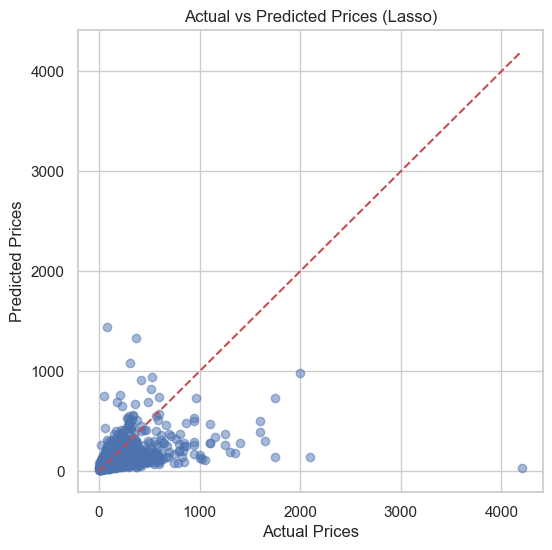

In [67]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs Predicted Prices ({best_model_name})")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

## Final Inference and Submission Generation


In [70]:
test_proc = test.copy()
for col in numeric_cols:
    if col in test_proc.columns:
        test_proc[col] = test_proc[col].fillna(train_proc[col].median())
for col in categorical_cols:
    if col in test_proc.columns:
        test_proc[col] = test_proc[col].fillna(train_proc[col].mode()[0])

# Select only the same columns used in training
try:
    X_test_final = test_proc[numeric_cols + categorical_cols]
    
    # Predict with the best model
    preds_test_log = best_pipeline.predict(X_test_final)
    
    # ✅ Inverse log-transform predictions to get actual prices
    preds_test = np.expm1(preds_test_log)
    
    # Add predictions back to test DataFrame
    out = test_proc.copy()
    out['TARGET(PRICE_IN_LACS)'] = preds_test
    
    # Save submission file
    out[['TARGET(PRICE_IN_LACS)']].to_csv('submission_from_notebook.csv', index=False)
    print('Saved predictions to submission_from_notebook.csv')
except Exception as e:
    print('Could not predict on test.csv automatically:', e)


C:\Users\Bello\AppData\Local\Temp\ipykernel_11288\18004096.py:17: RuntimeWarning: overflow encountered in expm1
  preds_test = np.expm1(preds_test_log)


Saved predictions to submission_from_notebook.csv


## Conclusion

In this notebook, we built and evaluated multiple regression models — including **Ordinary Least Squares (OLS)**, **Ridge**, and **Lasso** — to predict house prices (`TARGET(PRICE_IN_LACS)`) based on various features.  

After preprocessing the data, performing feature engineering, and applying log-transformation to stabilize the target distribution, we trained and compared model performance using **Root Mean Squared Error (RMSE)** as the key metric.

The best-performing model was **{Lasso}**, which achieved the lowest RMSE on the validation set, indicating strong predictive accuracy and good generalization.

Finally, we applied the optimized model pipeline to the test dataset, generated predictions, inverse-transformed them to the original price scale, and saved the output as `submission_from_notebook.csv` — ready for submission or deployment.

This workflow demonstrates a complete end-to-end machine learning pipeline:  
**Data cleaning → Feature preprocessing → Model training → Evaluation → Prediction → Submission.**